In [2]:
%load_ext autoreload
%autoreload 2

import sys, os
import matplotlib
import itertools
from matplotlib import animation, rc

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)

from IPython.display import HTML
import matplotlib.pyplot as plt

import numpy as np
import scipy as sp
import scipy.sparse as sps
import scipy.sparse.linalg as LAS

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Gauss-Seidel

Please note that this implementation is not optimal in various ways.

In [3]:
N = 5    # The number of interval
h = 1./N  # Lenght of each interval
print("h = ", h)

# Set tolerance
tolerance = h**2 / 4.

# This means we have N+1 points -> N-1 interior points
w = np.zeros((N+1, N+1))

# Set the boundary conditions
w[:, 0]  = 0.0 # x = 0
w[:, -1] = 0.0 # x = 1, 0 <= y <= 1/2
w[-1, :] = 0.0 # y = 0
w[0, :]  = 0.0 # y = 1
w[3, -1] = 1.0 
w[4, -1] = 1.0 
w[5, -1] = 1.0 
# x = 1, 1/2 < y <= 1
print(w)

# Create temporary buffer
wn = np.copy(w)

# Iterator
k = 0

for n in range(7):
    # Only iterate over the interior points.
    for i, j in itertools.product(range(1, N), range(1, N)):
        wn[i, j] = 0.25 * (wn[i-1, j] + w[i+1, j] + wn[i, j-1] + w[i, j+1])
    
    # Compute the difference between the old and new approximation
    error = np.max(np.abs(wn - w))
        
    # Replace the former approximation
    w[1:N, 1:N] = wn[1:N, 1:N]
       
    # Increment iteration counter
    k += 1
    
    # Print progress.
    print('k = {0:d}, error = {1:.4g}'.format(k, error))

#print('Required {0:d} iterations!\nEror = {1:.4g}.'.format(k, error))

h =  0.2
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]
k = 1, error = 0.3125
k = 2, error = 0.1094
k = 3, error = 0.0625
k = 4, error = 0.03271
k = 5, error = 0.02063
k = 6, error = 0.01372
k = 7, error = 0.00982


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


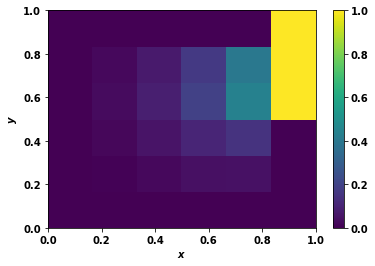

In [4]:
# Plot the solution
xx, yy = np.meshgrid(np.linspace(0, 1, N+2), np.linspace(0, 1, N+2))

# Have to reflect the w vector to match the data format that pcolor expects.
# For more information: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolor.html
plt.pcolor(xx, yy, w)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar()

# SOR

In [15]:
N = 50    # The number of interval
h = 1./N  # Lenght of each interval

# Set tolerance
tolerance = h**2 / 4.

# This means we have N+1 points -> N-1 interior points
w = np.zeros((N+1, N+1))

# Set the boundary conditions
w[:, 0]  = 0.0 # x = 0
w[:, -1] = 0.0 # x = 1
w[-1, :] = 0.0 # y = 0
w[0, :]  = 1.0 # y = 1

# Create temporary buffer
wn = np.copy(w)

# Iterator
k = 0

# Relaxation parameter -> TODO: compute the optimal value
omega = 1.5 

while True:
    # Only iterate over the interior points.
    for i, j in itertools.product(range(1, N), range(1, N)):
        wn[i, j] = 0.25 * (wn[i-1, j] + w[i+1, j] + wn[i, j-1] + w[i, j+1])
    
    # Compute the difference between the old and new approximation
    error = np.max(np.abs(wn - w))
        
    # Replace the former approximation
    w[1:N, 1:N] = (1. - omega) * w[1:N, 1:N] + omega * wn[1:N, 1:N]
       
    # Increment iteration counter
    k += 1
    
    # Print progress.
    # print('k = {0:d}, error = {1:.4g}'.format(k, error))
    
    if error < tolerance:
        break

print('Required {0:d} iterations!\nEror = {1:.4g}.'.format(k, error))

Required 461 iterations!
Eror = 9.997e-05.


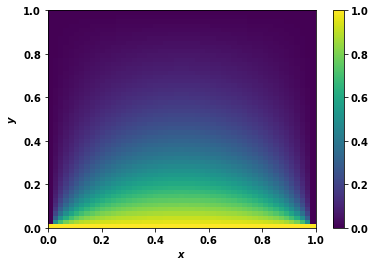

In [16]:
# Plot the solution
xx, yy = np.meshgrid(np.linspace(0, 1, N+2), np.linspace(0, 1, N+2))

# Have to reflect the w vector to match the data format that pcolor expects.
# For more information: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolor.html
plt.pcolor(xx, yy, w)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar()

# Analytical solution

The analytical solution is given by
$$ u(x, y) = 
    \sum_{k\ \mbox{odd}}^{\infty} \frac{-1}{\tanh(k \pi)} \frac{4}{k \pi} \left( -\tanh(k \pi)\cosh(k \pi y) + \sinh(k \pi y)\right) \sin\left( k \pi x\right) $$

In [115]:
def series(x, y, M):
    # x and y should be a meshgrid.
    u = np.zeros_like(x)
    
    for k in range(1, M, 2):
        u += (-1. / np.tanh(k * np.pi)) * (4. / (k * np.pi)) * (- np.tanh(k * np.pi) * np.cosh(k * np.pi * y) + np.sinh(k * np.pi * y)) * np.sin(k * np.pi * x)

    return u

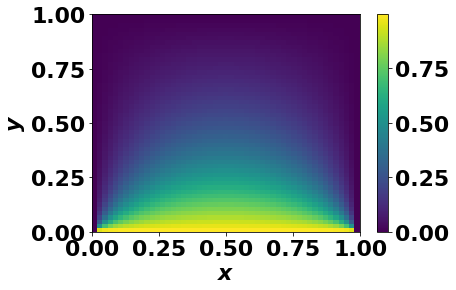

In [119]:
# Plot the solution
xx, yy = np.meshgrid(np.linspace(0, 1, N+1), np.linspace(0, 1, N+1))

# Create the analytical solution
u = series(xx, yy, 200)

# Have to reflect the w vector to match the data format that pcolor expects.
# For more information: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolor.html
xx, yy = np.meshgrid(np.linspace(0, 1, N+2), np.linspace(0, 1, N+2))

plt.pcolor(xx, yy, u)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar()

# Plot of error of Jacobi scheme

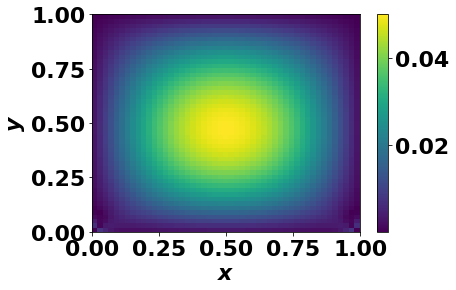

In [120]:
error = np.abs(u[1:N, 1:N] - w[1:N, 1:N])

# Plot the solution
xx, yy = np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))

# Have to reflect the w vector to match the data format that pcolor expects.
# For more information: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolor.html
plt.pcolor(xx, yy, error)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar()

Text(0, 0.5, 'Error')

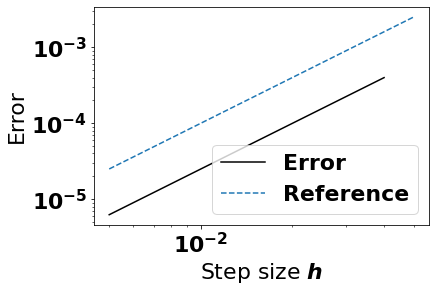

In [137]:
# Obtained from running the above code!
# The obtained error converges as expected (see below).
error = {0.04: 0.0003986, 0.02: 9.984e-5, 0.01: 2.5e-5, 0.005: 6.249e-6}

es = np.linspace(0.005, 0.05, 100)
ys = es**2

# Plot the error + a line with slope 2.
plt.loglog(error.keys(), error.values(), color='k', label='Error')
plt.loglog(es, ys, label='Reference', ls='--')
plt.legend(loc='best')
plt.xlabel('Step size $h$')
plt.ylabel('Error')